In [1]:
import os
import sys
import time
import json
import glob

import pandas as pd
import numpy as np
import regex as re

import pandas as pd
import glob
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from sklearn.metrics import f1_score, RocCurveDisplay, cohen_kappa_score

import bertopic
from bertopic import dimensionality, cluster
from bertopic import BERTopic

#from simpletransformers.classification import ClassificationModel, ClassificationArgs

from pymed import llm
from pymed import prompt

#from utils import medswitch
from utils.run_bertopic import run_bertopic
from utils.benchmark.preprocess import kfold_split
from utils.benchmark.metrics import acc_ci
from utils.benchmark.metrics import classification_metrics, substring_search_metrics
from utils.medswitch import map_generic

# options
%matplotlib inline
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', 30)

sns.set_style("white")
sns.set_context("paper")



/wynton/protected/home/ichs/bmiao/anaconda3/envs/llama/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/wynton/protected/home/ichs/bmiao/anaconda3/envs/llama/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/wynton/protected/home/ichs/bm

# Contraceptives

## Table 1: Demographics

In [1]:
import pandas as pd
from tableone import TableOne

# Load annotated medication data
annot_med_df = pd.read_parquet("./data/contraceptives/annotated_medications.parquet.gzip").reset_index(drop=True)

# Load patient data
pt_df = pd.read_parquet("./data/contraceptives/annotated_pt_demographics.parquet.gzip").reset_index(drop=True)
pt_df = pt_df[pt_df["med_switching_label"]!="No contraceptive with note"]
pt_df["age_firstcontraceptive"] = [(c-b).days/365 for c,b in 
                                   zip(pt_df["first_contraceptivestartdatekeyvalue"],
                                      pt_df["birthdate"])]
pt_df["final_mapped_med_generic_clean"] = [s if s is None else s[0] for s in pt_df["final_mapped_med_generic_clean"]]
pt_df["first_mapped_med_generic_clean"] = [s[0] if s is not None else s for s in pt_df["final_unique_med_trajectory"]]

# Variables of interes
plot_df = pt_df[["age_firstcontraceptive", 
                  "ucsfderivedraceethnicity_x", 
                  #"final_mapped_med_generic_clean",
                  "first_mapped_med_generic_clean",
                 "preferredlanguage",
                "med_switching_label"]]


plot_df = plot_df.apply(lambda x: x.replace("Unknown", None))
plot_df = plot_df.apply(lambda x: x.replace("*Unspecified", None))
plot_df = plot_df.apply(lambda x: x.replace("Unknown/Declined", None))
plot_df = plot_df.apply(lambda x: x.replace("Declined", None))

# Replace values that have <10 counts
plot_df["ucsfderivedraceethnicity_x"] = ["Other" if s not in ["White",
                                                            "Asian",
                                                            "Black or African American",
                                                             "Multi-Race/Ethnicity",
                                                             "Latinx"]
                                         #else "Unknown" if s is None # checking for missing values
                                         else s for s in plot_df["ucsfderivedraceethnicity_x"]]
plot_df["preferredlanguage"] = [None if type(s)!=str
           else "English" if s=="English"
            else "Spanish" if s=="Spanish"
           else "Other" for s in plot_df["preferredlanguage"]]

pt_table = TableOne(plot_df,
         groupby="med_switching_label",
                    display_all=True,
                    #tukey_test=True,
                    pval_adjust="bonferroni",
                    pval=True, 
                    htest_name=True)

pt_table.to_csv("./figures/Table1.csv")


In [63]:
# Get time to first contraceptive switch (difference between first and second contraceptive start)
annot_med_df["first_contraceptivestartdatekeyvalue"] = annot_med_df["patientdurablekey"].map(dict(zip(pt_df["patientdurablekey"], pt_df["first_contraceptivestartdatekeyvalue"])))
annot_med_df["days_first_contraceptive_to_curr_contraceptive"] = [(n-f).days for f,n in 
                                   zip(annot_med_df["first_contraceptivestartdatekeyvalue"],
                                      annot_med_df["startdatekeyvalue"])]

time_df = annot_med_df[annot_med_df["days_first_contraceptive_to_curr_contraceptive"]!=0]
time_df = time_df.sort_values(['patientdurablekey',
                'days_first_contraceptive_to_curr_contraceptive'],ascending=False).groupby('patientdurablekey').head(1)

time_dict = dict(zip(time_df["patientdurablekey"], time_df["days_first_contraceptive_to_curr_contraceptive"]))

pt_df["months_first_contraceptive_to_curr_contraceptive"] = [time_dict[pt] if label=="Contraceptive switch" else None for pt, label in zip(pt_df["patientdurablekey"], pt_df["med_switching_label"])]
pt_df["months_first_contraceptive_to_curr_contraceptive"] = pt_df["months_first_contraceptive_to_curr_contraceptive"]/30

pt_df["months_first_contraceptive_to_curr_contraceptive"].describe()

"""
count    1515.000000
mean       39.178262
std        32.008160
min         0.033333
25%        13.566667
50%        30.933333
75%        58.566667
max       142.100000
Name: months_first_contraceptive_to_curr_contraceptive, dtype: float64
"""


count    1515.000000
mean       39.178262
std        32.008160
min         0.033333
25%        13.566667
50%        30.933333
75%        58.566667
max       142.100000
Name: months_first_contraceptive_to_curr_contraceptive, dtype: float64

In [51]:
# Get type and numbers of contraceptive switches
curr_results = annot_med_df[annot_med_df["curr_med_change"]]
curr_results = curr_results.groupby(["prev_medication", "mapped_med_generic_clean"])["patientdurablekey"].count()
curr_results = curr_results.reset_index()
curr_results.columns = ["Previous medication", "New medication", "Count"]
curr_results = curr_results.set_index("Previous medication").sort_values("Count", ascending=False)
curr_results["Proportion"] = curr_results["Count"] / sum(curr_results["Count"])
curr_results.to_csv("./figures/supplement/TableS4.csv")


## Supplementary tables

In [110]:
# Table S2: Contraceptives mapping values
contraceptive_mapping = pd.read_json("./data/contraceptives/raw/contraceptives.json")
all_mapping = pd.DataFrame()

# Get manual mapping values
manual_mapping = contraceptive_mapping.copy(deep=True).dropna(subset=["med_class_mapping"])
manual_mapping = manual_mapping[["med_class_mapping"]]
manual_mapping.columns = ["Mapped value"]
all_mapping = pd.concat([all_mapping, manual_mapping])

# Get med class mapping values
contraceptive_mapping = contraceptive_mapping[contraceptive_mapping["med_class_mapping"].isna()]
del contraceptive_mapping["med_class_mapping"]

for col in contraceptive_mapping.columns:
    print(col)
    curr_df = contraceptive_mapping[[col]].dropna(subset=[col])

    curr_df.columns = ["Pharmaceutical Subclass"]
    curr_df["Mapped value"] = ["Oral" if "Oral" in m
                   else "Intrauterine" if "IUD" in m
                   else "Implant" if "Implant" in m
                   else "Intravaginal" if "Intravaginal" in m
                    else "Injectable" if "Injectable" in m
                    else "Transdermal" if "Transdermal" in m
                   else None for m in curr_df["Pharmaceutical Subclass"]]

    all_mapping = pd.concat([curr_df, all_mapping])
    
all_mapping.to_csv("./figures/supplement/TableS2.csv")


cdw_medname_pharmaceuticalsubclass
cdw_medgenericname_pharmaceuticalsubclass


## Figure S1: Automated prompt development evaluation

In [ ]:
# Load automated metrics
dev_results = "./data/contraceptives/gpt4/eval/prompt_dev_classification_metrics_micro.csv"
curr_results = pd.read_csv(dev_results, index_col=0)
curr_results.to_csv("./figures/supplement/Raw_FigureS1.csv")
#eval_df = pd.read_parquet("./butte/medswitch/data/ncdmard/gpt4/validation.parquet.gzip")

# Plot automated metrics
curr_results = curr_results.reset_index()
curr_results["setting"] = curr_results["sys_config"]+"_"+curr_results["task_config"]

for result in ["prev_medication", "mapped_med_generic_clean"]:
    metric = "micro_F1" 
    curr_results["95_ci"] = [acc_ci(accuracy, n=93) for accuracy in curr_results[metric]] #.groupby(["sys_config", "task_config"]).mean().sort_values("acc_norm")
    results_sub = curr_results[curr_results["index"]==result]
    
    fig, ax = plt.subplots(figsize=(8,6))
    sns.barplot(results_sub,
                hue="sys_config",
                x="task_config",
                y=metric,
                capsize=1,
                edgecolor="black",
                order=["default", "manual-function"],
                hue_order=["default", "general", "specialist"],
                palette="Blues")
    
    x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
    y_coords = [p.get_height() for p in ax.patches]
    
    ax.errorbar(x=x_coords, y=y_coords, yerr=results_sub['95_ci'], fmt='none', c='black')
    ax.set_title(result, fontsize=16)
    plt.xlabel("")
    plt.ylabel("MicroF1 (%)",fontsize=16,)
    ax.set_xticklabels(["Default Prompt", "Dictionary Prompt"], fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    plt.tick_params(left = True)
    #ax.set_xticks()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.figure.savefig(f"./figures/FigureS1_{result}.pdf", bbox_inches='tight')


# Figure 2: Human evaluation

In [320]:
# Create dataset for annotation
annot_med_df = pd.read_parquet("./data/contraceptives/gpt4/validation.parquet.gzip").reset_index(drop=True)
annot_med_df = annot_med_df[["note_deid_note_key", "note_text"]]

gpt4_df = pd.read_csv("./data/contraceptives/gpt4/prompt_dev/2023-11-13_gpt-4_specialist-sys-config_default-task-config_prompt_dev.csv")
reasons = gpt4_df[["Unnamed: 0", "reason_last_contraceptive_stopped"]]

annot_med_df = annot_med_df.merge(reasons,
                                  how="inner",
                                  left_on="note_deid_note_key",
                                  right_on="Unnamed: 0")
annot_med_df["Contraceptive started"] = np.nan
annot_med_df["Contraceptive stopped"] = np.nan
annot_med_df["Reason for stopping correct? (Y/N/NA)"] = np.nan
annot_med_df["Hallucination in reason? (Y/N/NA)"] = np.nan

annot_med_df = annot_med_df[['note_deid_note_key', 
                             'note_text', 
                             'Contraceptive started', 'Contraceptive stopped',
                             'reason_last_contraceptive_stopped',
                             'Reason for stopping correct? (Y/N/NA)',
                             'Hallucination in reason? (Y/N/NA)']].set_index("note_deid_note_key")
annot_med_df.to_csv("./data/contraceptives/annotation/annotation_set.csv")

# Provide annotators with dictionary
with open("./data/contraceptives/raw/contraceptives.json") as med_file:
    med_mapping = json.load(med_file)

full_map_dict = {}
for values in med_mapping.values():
    full_map_dict.update(values)

full_map_df = pd.DataFrame.from_dict(full_map_dict, orient="index")
full_map_df.columns = ["Contraceptive class"]
full_map_df.to_csv("./data/contraceptives/annotation/med_mapping_dictionary.csv")


In [22]:

# EE annotations (patient keys redacted)
annotated = pd.read_csv("./data/contraceptives/annotation/annotated_set_EE.csv", index_col=0)
del annotated["note_text"]

# Add silver standard labels
gpt4_df = pd.read_csv("./data/contraceptives/gpt4/eval/prompt_dev_evaluated_preds.csv", index_col=0)
# Slice and format values
curr_df = gpt4_df[(gpt4_df["sys_config"]=="default")&(gpt4_df["task_config"]=="default")]
del curr_df["sys_config"]
del curr_df["task_config"]
curr_df = curr_df.T.set_index("reason_last_contraceptive_stopped_labels")
curr_df = curr_df[["mapped_med_generic_clean_labels", "prev_medication_labels"]] # annotated labels

compare_df = annotated.merge(curr_df,
                   left_index=True, right_index=True,
                   how="inner")
compare_df = compare_df.replace(np.nan, "None")

pt_dict = pd.factorize(compare_df.reset_index()["index"])
pt_dict = dict(zip(pt_dict[1], pt_dict[0]))
compare_df.index = compare_df.index.map(pt_dict)

# Relabel
compare_df.columns = ["Contraceptive started - Human label", "Contraceptive stopped - Human label",
                      "GPT4 Extracted Reason", "Reason for stopping correct? (Y/N/NA)",
                      "Hallucination in reason? (Y/N/NA)",
                      "Start label inferred by evaluator?", "Stop label inferred by evaluator?",
                      "Start label redacted?", "Stop label redacted?", 
                      "Contraceptive started - Structured data",
                      "Contraceptive stopped - Structured data",
                     ]

compare_df.to_csv("./figures/supplement/TableS4.csv")


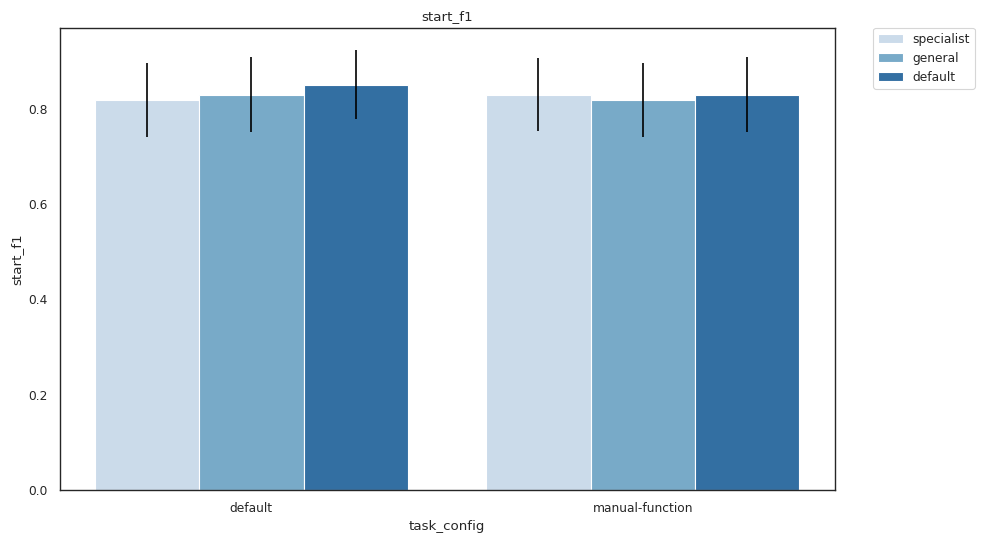

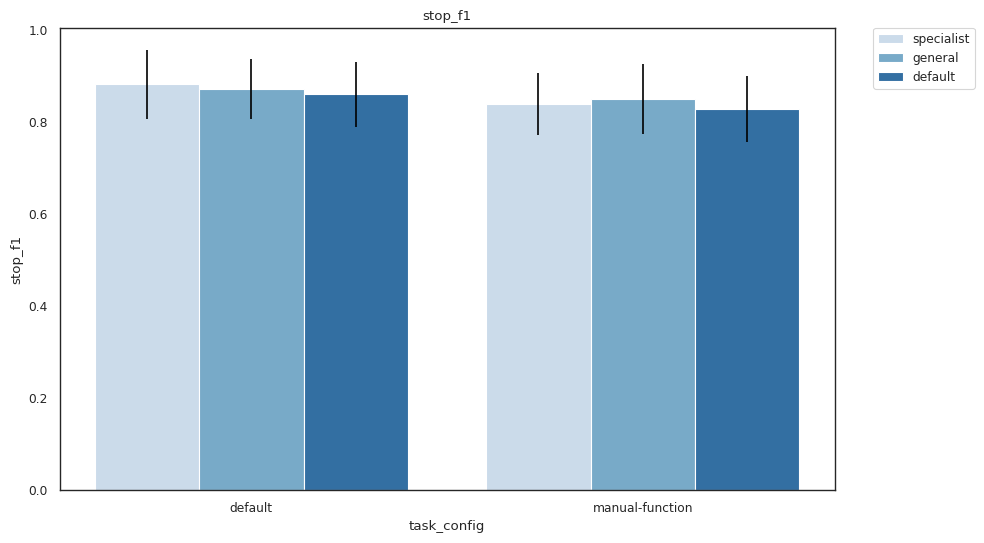

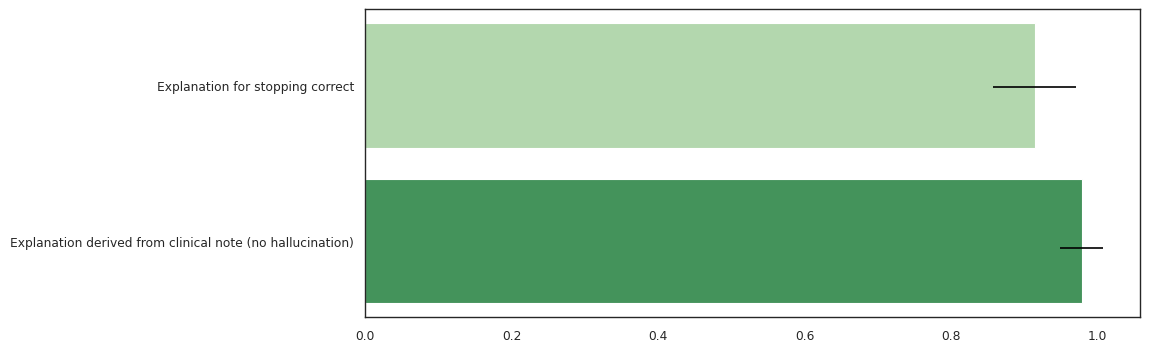

In [26]:
annotated = pd.read_csv("./data/contraceptives/annotation/annotated_set_EE.csv", index_col=0)
gpt4_df = pd.read_csv("./data/contraceptives/gpt4/eval/prompt_dev_evaluated_preds.csv", index_col=0)

# save values
human_class_metrics = []
concordance_metrics_text = {}
human_text_metrics = {}

# Calculate all metrics against human evaluation
for sys, task in set(zip(gpt4_df["sys_config"], gpt4_df["task_config"])):
    # Slice and format values
    curr_df = gpt4_df[(gpt4_df["sys_config"]==sys)&(gpt4_df["task_config"]==task)]
    del curr_df["sys_config"]
    del curr_df["task_config"]
    curr_df = curr_df.T.set_index("reason_last_contraceptive_stopped_labels")
    
    # Compare values for classification values
    compare_df = annotated.merge(curr_df,
                   left_index=True, right_index=True,
                   how="inner")
    compare_df = compare_df.replace(np.nan, "None")
    
    # Comparing human annotation ("Contraceptive started") to GPT-4 prediction (eg. "mapped_med_generic_clean_preds")
    start_f1 = f1_score(list(compare_df["Contraceptive started"]),
                        list(compare_df["mapped_med_generic_clean_preds"]),
                        average="micro")

    stop_f1 = f1_score(list(compare_df["Contraceptive stopped"]),
                        list(compare_df["prev_medication_preds"]),
                        average="micro")
    
    # Comparing human annotation ("Contraceptive started") to silver standard labels (eg. "mapped_med_generic_clean_labels")
    concordance_start_kappa = cohen_kappa_score(list(compare_df["Contraceptive started"]),
                        list(compare_df["mapped_med_generic_clean_labels"]))

    concordance_stop_kappa = cohen_kappa_score(list(compare_df["Contraceptive stopped"]),
                        list(compare_df["prev_medication_labels"]))
    
    # Comparing human and silver standard labels dropping where the human label is None
    concord_df = compare_df[compare_df["Contraceptive started"]!="None"]
    concordance_start_kappa_none_removed = cohen_kappa_score(list(concord_df["Contraceptive started"]),
                        list(concord_df["mapped_med_generic_clean_labels"]))

    concord_df = compare_df[compare_df["Contraceptive stopped"]!="None"]
    concordance_stop_kappa_none_removed = cohen_kappa_score(list(concord_df["Contraceptive stopped"]),
                        list(concord_df["prev_medication_labels"]))
    
    human_class_metrics.append({"sys_config":sys,
                        "task_config":task,
                        "start_f1":start_f1,
                        "stop_f1":stop_f1,
                        "concordance_start_kappa":concordance_start_kappa,
                        "concordance_stop_kappa":concordance_stop_kappa,
                                "concordance_start_kappa_none_removed":concordance_start_kappa_none_removed,
                                "concordance_stop_kappa_none_removed":concordance_stop_kappa_none_removed,
                        })
        
    '''
    'concordance_start_kappa': 0.5853114754098361,
  'concordance_stop_kappa': 0.21681749622926094,
  'concordance_start_kappa_none_removed': 0.9596560846560847,
  'concordance_stop_kappa_none_removed': 0.6435643564356436},
    '''  
    
    # Get values to compare reason automated scoring to human eval (for chosen prompt only)
    if (sys=="specialist")&(task=="default"):
        compare_df["reason_last_contraceptive_stopped_score_clean"] = compare_df["reason_last_contraceptive_stopped_score"].replace("None", 0.0)
        compare_df["reason_last_contraceptive_stopped_score_clean"] = pd.to_numeric(compare_df["reason_last_contraceptive_stopped_score_clean"])
        
        # No reason given in note or by GPT4
        reason_df = compare_df[(compare_df["Reason for stopping correct? (Y/N/NA)"]=="Y")&
                              (compare_df["reason_last_contraceptive_stopped"]=="None")]
        concordance_metrics_text["no_reason_correct_scores"] = dict(reason_df["reason_last_contraceptive_stopped_score_clean"].describe())
          
        # GPT4 and human evaluation match
        reason_df = compare_df[(compare_df["Reason for stopping correct? (Y/N/NA)"]=="Y")&
                              (compare_df["reason_last_contraceptive_stopped"]!="None")]
        concordance_metrics_text["reason_correct_scores"] = dict(reason_df["reason_last_contraceptive_stopped_score_clean"].describe())
        
        # GPT4 and human evaluation do not match
        reason_df = compare_df[(compare_df["Reason for stopping correct? (Y/N/NA)"]=="N")]
        concordance_metrics_text["reason_incorrect_scores"] = dict(reason_df["reason_last_contraceptive_stopped_score_clean"].describe())
        
        # Also save human eval score
        human_text_metrics["Explanation for stopping correct"] = compare_df["Reason for stopping correct? (Y/N/NA)"].value_counts(normalize=True).loc["Y"]
        human_text_metrics["Explanation derived from clinical note (no hallucination)"] = compare_df["Hallucination in reason? (Y/N/NA)"].value_counts(normalize=True).loc["N"]
        
        # And concordance
        preds = [1 if c>0 else 0 for c in list(compare_df["reason_last_contraceptive_stopped_score_clean"])]
        labels = [1 if c else 0 for c in compare_df["Reason for stopping correct? (Y/N/NA)"]=="Y"]
        human_text_metrics["softmax-auto-score_human_eval_F1_concordance"] = f1_score(preds, labels)
        #RocCurveDisplay.from_predictions(labels, preds)

# Plot classification metrics
plot_df = pd.DataFrame(human_class_metrics)
plot_df.to_csv("./figures/supplement/TableS5A.csv")

for metric in ["start_f1", "stop_f1"]:
    # plot
    fig, ax = plt.subplots(figsize=(10,6))
    ax = sns.barplot(plot_df, hue="sys_config", x="task_config", 
                     order=["default", "manual-function"],
                     y=metric,palette="Blues")
    
    # add CI
    plot_df[f"{metric}_95_ci"] = [acc_ci(accuracy, n=93) for accuracy in plot_df[metric]]
    x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
    y_coords = [p.get_height() for p in ax.patches]
    
    ax.set_title(metric)
    ax.errorbar(x=x_coords, y=y_coords, yerr=plot_df[f'{metric}_95_ci'], fmt='none', c='black')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.figure.savefig(f"./figures/Figure2_{metric}.pdf", bbox_inches='tight')

# Plot text human evaluation metrics
plot_df = pd.DataFrame.from_dict(human_text_metrics, orient="index")
plot_df = plot_df.iloc[:2, :]

fig, ax = plt.subplots(figsize=(10,4))
ax = sns.barplot(data=plot_df.T, orient="h", palette="Greens")
x_coords = [p.get_width() for p in ax.patches]
y_coords = [p.get_y() + 0.45 * p.get_width() for p in ax.patches]
ax.errorbar(x=x_coords, y=y_coords, fmt='none', c='black',
           xerr=[acc_ci(accuracy, n=93) for accuracy in plot_df[0]],)

plot_df.to_csv("./figures/supplement/TableS5B.csv")
ax.figure.savefig(f"./figures/Figure3C.pdf", bbox_inches='tight')

# Save concordance values from text
plot_df = pd.DataFrame.from_dict(concordance_metrics_text, orient="columns")
plot_df.to_csv("./figures/supplement/TableS5C.csv")



## Figure 4: Test values & baseline

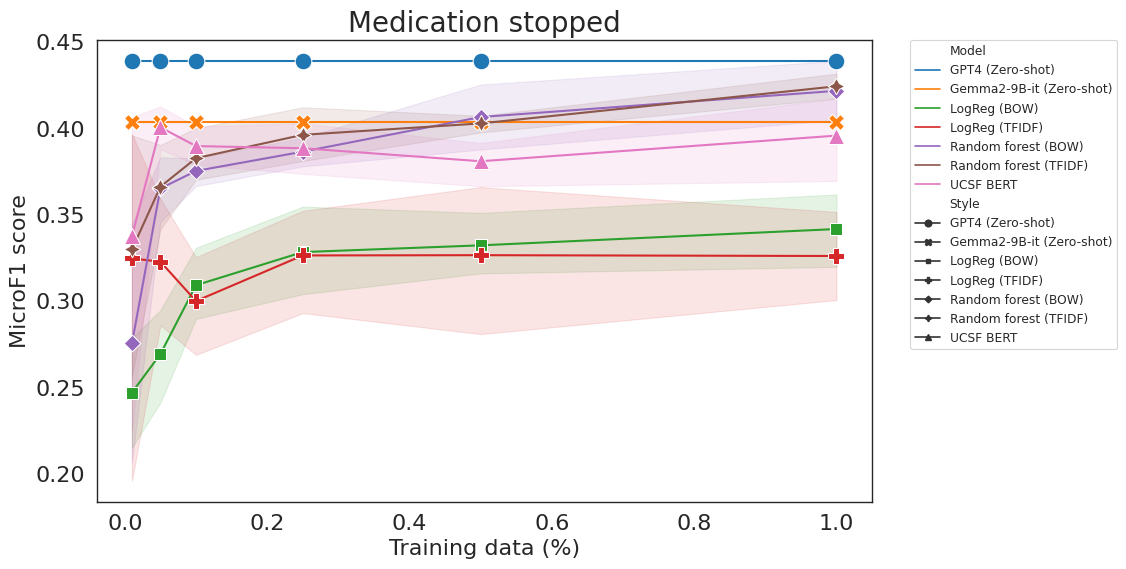

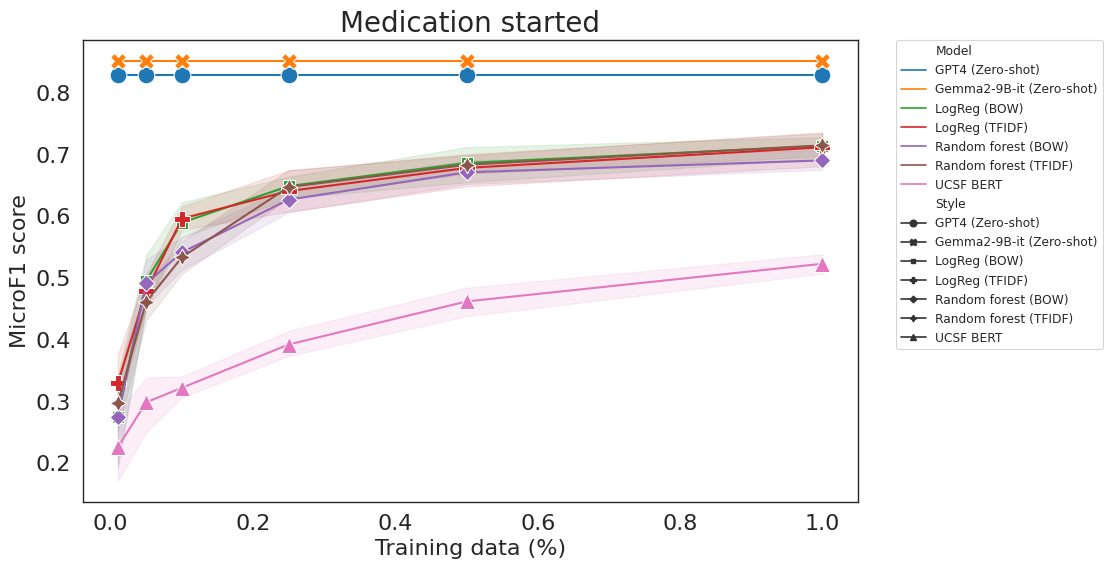

In [33]:
all_files = glob.glob("./data/contraceptives/baseline/*.csv")

def _parse_baseline_file(text):
    model = ["logreg" if "logreg" in text 
             else "ucsfbert" if "ucsfbert" in text else "rf"][0]
    target = ["prev_medication" if "prev_medication" in text 
              else "mapped_med_generic_clean" if "mapped_med_generic_clean" in text
              else ""][0]
    features = ["_tfidf" if "_tfidf" in text 
                else "_bow" if "_bow" in text
               else ""][0]
    date = text.split("/")[-1].split("_")[0]
    return {"model":model,
           "target":target,
           "features":features,
           "date":date}

med_class_name = "contraceptives"
all_data = pd.DataFrame()

# Get baseline values
for file in all_files:
    model_params = _parse_baseline_file(file)
    #plot_df = pd.read_csv(f"./data/{med_class_name}/baseline/{date}_kfold_{model_params['model']}_{model_params['target']}{model_params['features']}.csv", index_col=0)
    plot_df = pd.read_csv(file)
    plot_df["class"] = ["accuracy" if val=="micro avg" else val for val in plot_df["class"]]
    plot_df = plot_df[plot_df["class"]=="accuracy"]
    #plot_df = plot_df[plot_df["subsample_percent"]==1]
    plot_df = plot_df[plot_df["kfold"]!="Full average"]
    plot_df["date"] = model_params['date']
    plot_df["Model"] = model_params['model'] + model_params['features'] + "_" + model_params['date']
    plot_df["target"] = model_params['target']
    
    all_data = pd.concat([all_data, plot_df])

#all_data = all_data[all_data["model"]!="ucsfbert_2023-09-24"]
all_data = all_data[all_data["date"].isin(["2023-11-13", "2023-11-20"])]

# Get GPT4 values
plot_df = pd.read_csv("./data/contraceptives/gpt4/eval/test_classification_metrics_micro.csv")
plot_df.columns = ["target", "acc", "acc_norm", "f1-score", "micro_precision", "micro_recall", "sys_config", "task_config"]
plot_df = plot_df[["target", "f1-score"]]
plot_df["Model"] = "GPT4 (Zero-shot)"
subsamples = pd.DataFrame({"subsample_percent":[0.01, 0.05, 0.1 , 0.25, 0.5 , 1.  ,0.01, 0.05, 0.1 , 0.25, 0.5 , 1.  ],
                          "outer_join":[0,0,0,0,0,0,1,1,1,1,1,1]})
plot_df = subsamples.merge(plot_df, left_on="outer_join", right_index=True, how="outer")
all_data = pd.concat([all_data, plot_df])

'''
'''
# Get open source values
plot_df = pd.read_csv("./data/contraceptives/open_source/test_classification_metrics_micro.csv", index_col=0)
plot_df.columns = ["acc", "acc_norm", "f1-score", "micro_precision", "micro_recall", "dataset", "model", "date"]
plot_df["target"] = plot_df.index
plot_df = plot_df[plot_df["model"]=="gemma2-9b-it"]
plot_df["Model"] = "Gemma2-9B-it (Zero-shot)"

# Create line
plot_df = plot_df[["target", "f1-score", "Model"]]
plot_df = plot_df.reset_index(drop=True)

subsamples = pd.DataFrame({"subsample_percent":[0.01, 0.05, 0.1 , 0.25, 0.5 , 1.  ,0.01, 0.05, 0.1 , 0.25, 0.5 , 1.  ],
                          "outer_join":[0,0,0,0,0,0,1,1,1,1,1,1]})
plot_df = subsamples.merge(plot_df, left_on="outer_join", right_index=True, how="outer")
all_data = pd.concat([all_data, plot_df])


# Clean up 
all_data["target"] = ["Medication started" if "mapped_med_generic_clean" in m
                     else "Medication stopped" if "prev_medication" in m 
                      else None for m in all_data["target"]]
all_data = all_data.dropna(subset="target") # remove unmapped values
all_data["Model"] = ["Random forest (TFIDF)" if "rf_tfidf" in m
                     else "Random forest (BOW)" if "rf_bow" in m
                     else "LogReg (TFIDF)" if "logreg_tfidf" in m
                     else "LogReg (BOW)" if "logreg_bow" in m
                     else "UCSF BERT" if "ucsfbert" in m
                     else m for m in all_data["Model"]]
all_data["Style"] = all_data["Model"]

# Format
for target in all_data['target'].unique():
    fig, ax = plt.subplots(figsize=(10,6))
    plot_data = all_data[all_data["target"]==target]
    sns.lineplot(data=plot_data, 
                 x="subsample_percent", 
                 y="f1-score", 
                 hue="Model",
                 style="Style",
                 dashes=False,
                 markers=True,
                 linewidth=1.5,
                 markersize=12,
                 hue_order=['GPT4 (Zero-shot)', 'Gemma2-9B-it (Zero-shot)', 'LogReg (BOW)', 'LogReg (TFIDF)',
                        'Random forest (BOW)', 'Random forest (TFIDF)',
                        'UCSF BERT'],
                 style_order=['GPT4 (Zero-shot)', 'Gemma2-9B-it (Zero-shot)','LogReg (BOW)', 'LogReg (TFIDF)',
                        'Random forest (BOW)', 'Random forest (TFIDF)',
                        'UCSF BERT'],
                 errorbar=('ci', 95),
                alpha=1,
                err_kws={"alpha": 0.12}) #hue="kfold"
    ax.set_title(target, size=20)
    ax.set_xlabel("Training data (%)", size=16)
    ax.set_ylabel("MicroF1 score", size=16)
    ax.set_xticklabels(labels=ax.get_xticklabels(), size=16)
    ax.set_yticklabels(labels=ax.get_yticklabels(), size=16)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    ax.figure.savefig(f"./figures/Figure3_{target}.pdf", bbox_inches='tight')

# raw baseline values
all_data.to_csv("./figures/supplement/TableS7.csv")



In [ ]:
# Table of other open source values


# Figure 5: BERTopic

In [ ]:
# Load data
reasons_test_df = pd.read_csv("./data/contraceptives/gpt4/2023-11-13_gpt-4_specialist-sys-config_default-task-config_test.csv", index_col=0)
reasons_dev_df = pd.read_csv("./data/contraceptives/gpt4/prompt_dev/2023-11-13_gpt-4_specialist-sys-config_default-task-config_prompt_dev.csv", index_col=0)
reasons_orig_df = pd.concat([reasons_test_df, reasons_dev_df])

# contraceptives
model, reasons_df = run_bertopic(
    docs=list(reasons_orig_df["reason_last_contraceptive_stopped"]),
    med_class = "contraceptives",
    n_neighbors = 5, 
    n_components = 3, #3
    min_topic_size=10,
    seed=0,
    nr_topics="auto",
    **{"width":250, "height":300}
)

# merge topics
reasons_df.to_csv("./data/contraceptives/raw/ucsf-bertopic-model.csv")
model.merge_topics(docs=list(reasons_df["docs"]), topics_to_merge=[[1,2, 9], [3, 4], [5, 8, 13, 14, 17, 18], [6,12]])
model.save("./data/contraceptives/raw/ucsf-bertopic-model", save_embedding_model=False)



In [ ]:

model = BERTopic.load("./data/contraceptives/raw/ucsf-bertopic-model")

# Load data
reasons_test_df = pd.read_csv("./data/contraceptives/gpt4/2023-11-13_gpt-4_specialist-sys-config_default-task-config_test.csv", index_col=0)
reasons_dev_df = pd.read_csv("./data/contraceptives/gpt4/prompt_dev/2023-11-13_gpt-4_specialist-sys-config_default-task-config_prompt_dev.csv", index_col=0)
reasons_orig_df = pd.concat([reasons_test_df, reasons_dev_df])

# reassign values originally labeled as -1
probs_df = pd.DataFrame(model.probabilities_)
reasons_df = pd.read_csv("./data/contraceptives/raw/ucsf-bertopic-model.csv", index_col=0)
reasons_df["new_topics"] = model.probabilities_.argmax(axis=1)

# Update model
# Fit BERTopic without actually performing any clustering
new_topic_model = BERTopic(
        embedding_model=bertopic.backend.BaseEmbedder(),
        umap_model=dimensionality.BaseDimensionalityReduction(),
        hdbscan_model=bertopic.cluster.BaseCluster(),
        ctfidf_model=bertopic.vectorizers.ClassTfidfTransformer(reduce_frequent_words=False),
    calculate_probabilities=True
)
topics, probs = new_topic_model.fit_transform(list(reasons_df["docs"].astype(str)),
                                          y=list(reasons_df["new_topics"].astype(str)))
all_probs, _ = new_topic_model.approximate_distribution(list(reasons_df["docs"].astype(str)))
reasons_df["prob"] = all_probs.max(axis=1)
probs_df = pd.DataFrame(all_probs)
reasons_df = pd.concat([reasons_df,probs_df], axis=1)

# add metadata
reasons_df["orig_reason"] = list(reasons_orig_df["reason_last_contraceptive_stopped"])
reasons_df["deid_note_key"] = reasons_orig_df.index

# Add GPT4 extracted labels for switching
with open("./data/contraceptives/raw/contraceptives.json", "r") as map_file:
    med_mapping = json.load(map_file)

reasons_df["gpt4_contraceptive_started_clean"] = list(reasons_orig_df["new_contraceptive"])
reasons_df["gpt4_contraceptive_started_clean"] = [None if type(p)!=str else map_generic(p,
                                               med_mapping["med_class_mapping"],
                                               return_value=False) for p in reasons_df["gpt4_contraceptive_started_clean"]]
reasons_df["gpt4_contraceptive_stopped_clean"] = list(reasons_orig_df["last_contraceptive"])
reasons_df["gpt4_contraceptive_stopped_clean"] = [None if type(p)!=str 
                                                  else map_generic(p,
                                                                   med_mapping["med_class_mapping"], 
                                                                   return_value=False)
                                                  for p in reasons_df["gpt4_contraceptive_stopped_clean"]]


# Add patient demographics
annotated_df = pd.read_parquet("./data/contraceptives/annotated_medications.parquet.gzip")
pt_df = pd.read_parquet("./data/contraceptives/annotated_pt_demographics.parquet.gzip")
med_note_dict = dict(zip(annotated_df["note_deid_note_key"], annotated_df["patientdurablekey"]))

reasons_df["patientdurablekey"] = reasons_df["deid_note_key"].map(med_note_dict)
reasons_df = reasons_df.merge(pt_df, left_on="patientdurablekey", right_on="patientdurablekey", how="inner")

# Create values for topic labels
topic_labels = new_topic_model.generate_topic_labels()

topic_df = new_topic_model.get_topic_freq()
topic_df["topic_names"] = topic_df["Topic"].map(dict(zip([int(s.split("_")[0]) for s in topic_labels], topic_labels)))
#topic_df.to_csv("./figures/supplement/TableS6A.csv")

# Save 
reasons_df = reasons_df.set_index("deid_note_key")
reasons_df = reasons_df[["docs", "topics","new_topics", "prob",
                       "orig_reason", "ucsfderivedraceethnicity_x",
                      "gpt4_contraceptive_started_clean",
                      "gpt4_contraceptive_stopped_clean",
                      'preferredlanguage',
                       'ethnicity',
                       'firstrace',
                      'smokingstatus',
                       'primaryfinancialclass',
                       'highestlevelofeducation'] + list(range(reasons_df["new_topics"].nunique()))]
reasons_df.to_csv("./data/contraceptives/raw/ucsf-bertopic-model_updated.csv")

# Save new figures (TODO: update to prettier plots)
fig = new_topic_model.visualize_barchart(top_n_topics=reasons_df["new_topics"].nunique(),
                                         topics=list(range(1,reasons_df["new_topics"].nunique())),
                                         n_words=8,
                                         height=300)#.visualize_documents(docs, reduced_embeddings=embeddings, )


## Subgroup analysis

(828, 9)
(828, 4)


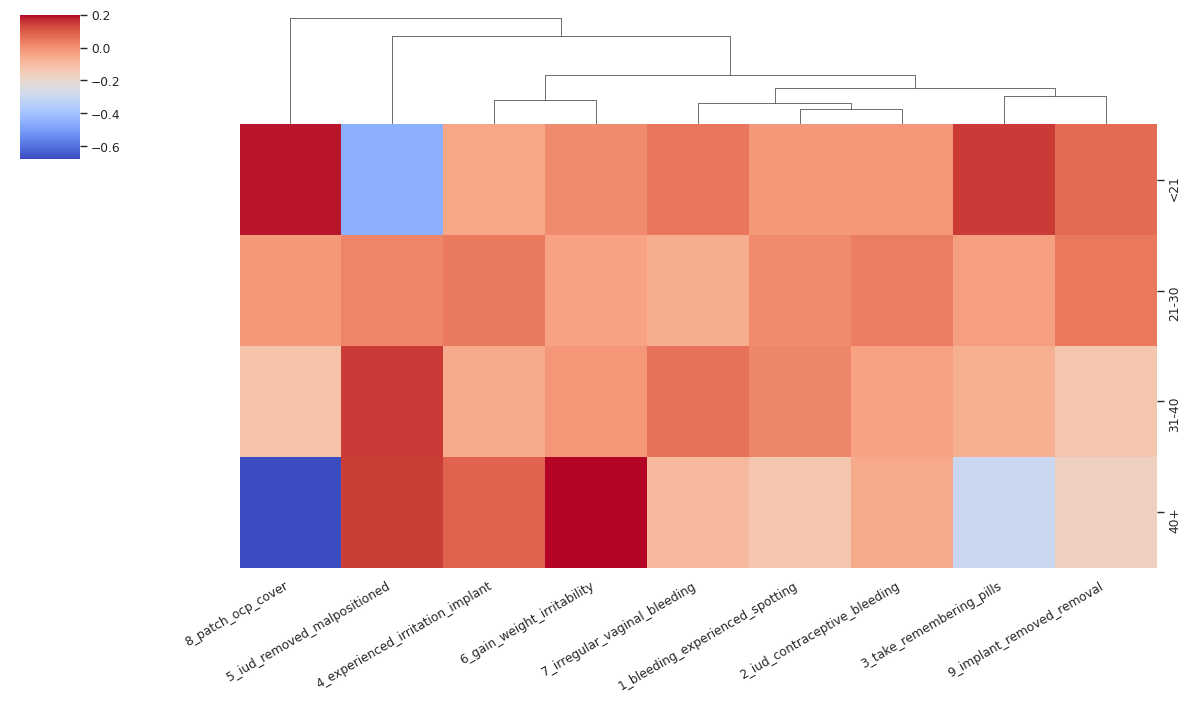

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
topic_labels = pd.read_csv("./figures/supplement/TableS6A.csv", index_col=0)
subgroups_df = pd.read_csv("./data/contraceptives/raw/ucsf-bertopic-model_updated.csv", index_col=0)

subgroups_df = subgroups_df[subgroups_df["new_topics"]!=0]

# Group and drop unknown race
subgroups_df["ucsfderivedraceethnicity_x"] = ["Other" if type(s)!=str
                                   else s if s in ["White",
                                                   "Asian",
                                                   "Latinx",
                                                   "Black or African American",
                                                   "Multi-Race/Ethnicity"]   
                                  else "Other" for s in subgroups_df["ucsfderivedraceethnicity_x"]]

### Add age data to each note
annotated_df = pd.read_parquet("./data/contraceptives/annotated_medications.parquet.gzip")
pt_df = pd.read_parquet("./data/contraceptives/annotated_pt_demographics.parquet.gzip")

subgroups_df = subgroups_df.merge(annotated_df[["note_deid_note_key", "startdatekeyvalue", "patientdurablekey"]], left_index=True, right_on="note_deid_note_key", how="left")
subgroups_df["birthdate"] = subgroups_df["patientdurablekey"].map(dict(zip(pt_df["patientdurablekey"], pt_df["birthdate"])))
subgroups_df["age"] = [(c-b).days/365 for c,b in 
                                   zip(subgroups_df["startdatekeyvalue"],
                                      subgroups_df["birthdate"])]

subgroups_df = subgroups_df.set_index("note_deid_note_key")
subgroups_df["age_group"] = ["<21" if age<21
                            else "21-30" if age <31
                             else "31-40" if age <41
                            else "40+" for age in subgroups_df["age"]]
subgroups_df["age_group"] = pd.CategoricalIndex(subgroups_df["age_group"], categories= ["<21", "21-30", "31-40", "40+"])
subgroups_df.sort_values("age_group", inplace=True)

plot_dict = {"age_group":"FigureS_AgeAnalysis.pdf",
            "ucsfderivedraceethnicity_x":"Figure4B.pdf"}
            #"gpt4_contraceptive_started_clean":"supplement/FigureS3A.pdf",
            #"gpt4_contraceptive_stopped_clean":"supplement/FigureS3B.pdf"}


for subgroup, file_name in plot_dict.items():
    # topic weight for note n and topic k
    q_nk = subgroups_df[[str(s) for s in range(1,subgroups_df["new_topics"].nunique()+1) 
                         if str(s) in subgroups_df.columns]] 
    q_nk.columns = [int(s) for s in q_nk.columns] # easier to work with
    print(q_nk.shape)

    #race weight for topic k
    y_k = pd.get_dummies(subgroups_df[subgroup])  
    print(y_k.shape)

    # Get weighted probabilities
    wt_probs = np.matmul(q_nk.T.values, y_k).T 
    wt_probs.columns = [int(s) for s in q_nk.columns]
    wt_probs = wt_probs / (q_nk.sum(axis=0))
    wt_probs = len(subgroups_df) * wt_probs.T.divide(y_k.sum())
    wt_probs = wt_probs.dropna(how="all") #
    wt_probs = wt_probs.T

    wt_probs = np.log10(wt_probs)
    wt_probs = wt_probs.replace(-np.inf, 0)
    topic_label_dict = dict(zip(topic_labels["Topic"], topic_labels["topic_names"]))
    wt_probs.columns = [topic_label_dict[int(s)] for s in wt_probs.columns] 

    '''
    fig, ax = plt.subplots(figsize=(14,8))
    ax = sns.heatmap(wt_probs, vmax=3.5) #figsize=(14,8)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right');
    '''
    row_cluster = False if subgroup="age_group" else True
    ax = sns.clustermap(wt_probs, row_cluster=row_cluster, cmap="coolwarm", figsize=(12,8)) #vmax=2.5, coolwarm
    plt.setp(ax.ax_heatmap.get_xticklabels(), rotation=30, ha="right");
    ax.savefig(f"./figures/{file_name}")



In [ ]:
mean      27.978794
std        8.024122


In [37]:
subgroups_df["age"].describe()
"""
count    828.000000
mean      27.978794
std        8.024122
min       12.194521
25%       21.139726
50%       27.387671
75%       33.547945
max       50.435616
"""

count    828.000000
mean      27.978794
std        8.024122
min       12.194521
25%       21.139726
50%       27.387671
75%       33.547945
max       50.435616
Name: age, dtype: float64

In [35]:
from tableone import TableOne
pt_table = TableOne(subgroups_df[["ucsfderivedraceethnicity_x", "new_topics"]],
                    groupby="ucsfderivedraceethnicity_x",
                    display_all=True,
                    categorical=["new_topics"],
                    #tukey_test=True,
                    pval_adjust="bonferroni",
                    pval=True, 
                    htest_name=True,
                   row_percent=False)



### Supplemental: Note length distribution

In [19]:
# Get length of notes
files = glob.glob("./data/contraceptives/gpt4/prompt_dev/2023-11-13_*")
valid_data = [pd.read_csv(fpath) for fpath in files]
test_set = pd.read_csv("./data/contraceptives/gpt4/2023-11-13_gpt-4_specialist-sys-config_default-task-config_test.csv")

print(valid_data[0]["prompt_tokens"].describe()) # test set
print(test_set["prompt_tokens"].describe()) # validation set
'''
count      93.000000
mean      940.967742
std       709.931418
min       224.000000
25%       438.000000
50%       762.000000
75%      1223.000000
max      5102.000000
Name: prompt_tokens, dtype: float64

count    1871.000000
mean      999.102619
std       745.753143
min       238.000000
25%       467.000000
50%       765.000000
75%      1329.000000
max      6856.000000
Name: prompt_tokens, dtype: float64
'''
# Get inference costs
all_data = pd.concat(valid_data)
all_data = pd.concat([all_data, test_set])
input_tok = all_data["prompt_tokens"].sum()
output_tok = all_data["completion_tokens"].sum()

cost = (0.03 *input_tok/1000) + (0.06*output_tok/1000)
#total cost = $78.40


count      93.000000
mean      940.967742
std       709.931418
min       224.000000
25%       438.000000
50%       762.000000
75%      1223.000000
max      5102.000000
Name: prompt_tokens, dtype: float64
count    1871.000000
mean      999.102619
std       745.753143
min       238.000000
25%       467.000000
50%       765.000000
75%      1329.000000
max      6856.000000
Name: prompt_tokens, dtype: float64


78.3945

### Supplemental: Open-source models

In [3]:
# Open source validation set against structured data
valid_eval = pd.read_csv("./data/contraceptives/open_source/prompt-dev_classification_metrics_micro.csv", index_col=0)
valid_eval["expert"] = [True if "expert" in v else False for v in valid_eval.index]
valid_eval["Label"] = ["Medication Started" if "mapped_med_generic_clean" in v
                         else "Medication Stopped" for v in valid_eval.index]

table_plot_df = valid_eval[~valid_eval["expert"]]
table_plot_df = table_plot_df.groupby(["Label", "model"])[["micro_F1"]].first()
table_plot_df.columns = ["MicroF1 (vs Structured data)"]

# Add open source validation set evaluated against human annotation
expert_df = valid_eval[valid_eval["expert"]]
expert_df = expert_df.groupby(["Label", "model"])[["micro_F1"]].first()
expert_df.columns = ["MicroF1 (vs Expert Annotation)"]
table_supplement_df = table_plot_df.join(expert_df)
table_supplement_df.to_csv("./figures/supplement/TableS8.csv")

# Open source test set evaluation
test_eval = pd.read_csv("./data/contraceptives/open_source/test_classification_metrics_micro.csv", index_col=0)
test_eval["expert"] = [True if "expert" in v else False for v in test_eval.index]
test_eval["Label"] = ["Medication Started" if "mapped_med_generic_clean" in v
                         else "Medication Stopped" for v in test_eval.index]
test_eval = test_eval.groupby(["Label", "model"])[["micro_F1"]].first()
test_eval.columns = ["MicroF1 (vs Structured data)"]
test_eval.to_csv("./figures/supplement/TableS9.csv")

